# Pre-processing from LPI radar signals

In [ ]:
# import os
# import glob
# import pandas as pd
# import json
# import re

# raw_data_path = "/data/kiwan/dataset-CWD-10/"
# signal_types = ['Barker', 'Costas', 'Frank', 'LFM', 'P1', 'P2', 'P3', 'P4']

# output_json = 'CWD signal dataset.json'

# signals_dict = {}

# def extract_snr_from_filename(filename):
#     match = re.search(r'snr-?0*(\d+)', filename)
#     if match:
#         return int(match.group(1))
#     return None

# for signal in signal_types:
#     signal_csvs = glob.glob(os.path.join(raw_data_path, signal, '*.csv'))
#     signals_dict[signal] = {}  
    
#     for csv_file in signal_csvs:
#         snr_value = extract_snr_from_filename(csv_file)
#         print(f"Processing {csv_file} with SNR {snr_value}")
        
#         if snr_value is not None:
#             df = pd.read_csv(csv_file, header=None)
            
#             if snr_value not in signals_dict[signal]:
#                 signals_dict[signal][snr_value] = []
            
#             signals_dict[signal][snr_value].extend(df.values.tolist())
#         else:
#             print(f"Warning: SNR not found in {csv_file}")

# with open(output_json, 'w') as f:
#     json.dump(signals_dict, f, indent=4)

# print(f"All signals have been merged by SNR into {output_json}")


In [9]:

import os
import argparse
import numpy as np

import shap
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

import _config as c
from models.LSTM import BiLSTM
from models.Attention import Transformer
from explainer import LRP
    
criterion = nn.CrossEntropyLoss()

parser = argparse.ArgumentParser(description='Training parameters')
parser.add_argument('-m', '--mode', type=str, default='train', help='Mode of operation (train/eval)')

parser.add_argument('-smin','--snr_min', type=int, default=0, help='Minimum SNR value')
parser.add_argument('-smax','--snr_max', type=int, default=16, help='Maximum SNR value')
parser.add_argument('--split_size', type=float, default=0.8, help='Train/Test split size')
parser.add_argument('--batch_size', type=int, default=32, help='Batch size for training')
parser.add_argument('--num_epochs', type=int, default=500, help='Number of epochs for training')
parser.add_argument('--learning_rate', type=float, default=0.001, help='Learning rate for optimizer')
parser.add_argument('--weight_decay', type=float, default=1e-5, help='Weight decay for optimizer')
parser.add_argument('--input_size', type=int, default=2, help='Input size for the model')
parser.add_argument('--hidden_size', type=int, default=128, help='Hidden size for the model')
parser.add_argument('--num_layers', type=int, default=2, help='Number of layers in the model')
parser.add_argument('--num_classes', type=int, default=len(c.signalTypes[:c.typeSize]), help='Number of output classes')

args = parser.parse_args(args=[])

params = {
    'snr_min': args.snr_min,
    'snr_max': args.snr_max,
    'split_size': args.split_size,
    'batch_size': args.batch_size,
    'num_epochs': args.num_epochs,
    'learning_rate': args.learning_rate,
    'weight_decay': args.weight_decay,
    'input_size': args.input_size,
    'hidden_size': args.hidden_size,
    'num_layers': args.num_layers,
    'num_classes': args.num_classes
}

def train_set(dataset, mtype='LSTM'):
    print(f"Size of train dataset: {len(dataset)}")
    for snr in range(params['snr_min'], params['snr_max']+1, 2):
        print(f"\nTraining model for SNR: {snr}...")
        ckpt = os.path.join("./ckpts/", snr_str:=f"-{snr}dB" if snr != 0 else "0dB")
        os.makedirs(ckpt, exist_ok=True)
        
        if mtype == 'LSTM':
            model = BiLSTM(params['input_size'], params['hidden_size'], 
                        params['num_layers'], params['num_classes'])
        elif mtype == 'Attention':
            model = Transformer(params['input_size'], params['hidden_size'], 
                    params['num_layers'], params['num_classes'], nhead=8, dropout=0.3)
        
        model = nn.DataParallel(model, device_ids=[0, 1])
        model.to(c.device)
        
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], 
                                                    weight_decay=params['weight_decay'])
        
        snr_dataset = [(data, label, data_snr) for data, label, data_snr in dataset if data_snr == snr]
        snr_loader = DataLoader(snr_dataset, batch_size=params['batch_size'], shuffle=True, collate_fn=model.collate)
            
        # best_state, best_loss = model.train_model(snr_loader, criterion, optimizer, params['num_epochs'], c.device, snr_str, ckpt)
        best_state, best_loss = model.module.train_model(snr_loader, criterion, optimizer, params['num_epochs'], c.device, snr_str, ckpt)

        save_point = f'{ckpt}/{mtype}_{snr_str}_{best_loss:.4f}.pt'
        
        torch.save(best_state, save_point)
        print(f"Model checkpoint saved at {save_point}")

def eval_set(dataset, mtype='LSTM'):
    print(f"Size of test dataset: {len(dataset)}")
    for snr in range(params['snr_min'], params['snr_max']+1, 2):
        ckpt = os.path.join("./ckpts/", snr_str:=f"-{snr}dB" if snr != 0 else "0dB")
        ckpts = [f for f in os.listdir(ckpt) if f.endswith(".pt")]
        
        if mtype == 'LSTM':
            model = BiLSTM(params['input_size'], params['hidden_size'], 
                        params['num_layers'], params['num_classes']).to(c.device)
        elif mtype == 'Attention':
            model = Transformer(params['input_size'], params['hidden_size'], 
                    params['num_layers'], params['num_classes'], nhead=8, dropout=0.3).to(c.device)
            
        model.load_state_dict(torch.load(f"{ckpt}/{ckpts[0]}"))
        model.eval()
        
        snr_dataset = [(data, label, data_snr) for data, label, data_snr in dataset if data_snr == snr]
        snr_loader = DataLoader(snr_dataset, batch_size=params['batch_size'], shuffle=True, collate_fn=model.collate)
        
        total_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for batch in snr_loader:
                data, labels = batch[0].to(c.device), batch[1].to(c.device)
                outputs = model(data)
                loss = criterion(outputs, labels)
                total_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                
        acc = correct / total * 100
        avg_loss = total_loss / len(snr_loader)
        
        print(f"SNR -{snr}dB | Accuracy: {acc:.2f}% | Average Loss: {avg_loss:.4f}")
        
        
import matplotlib.pyplot as plt
import numpy as np
import os

def explain_set(dataset, mtype='LSTM'):
    """
    설명 및 기여도 분석을 위한 함수.
    주어진 데이터셋과 모델을 사용하여 각 데이터에 대한 LRP 기여도 계산 및 시각화.
    
    Parameters:
        - dataset: 입력 데이터셋
        - mtype: 모델 타입 ('LSTM', 'Attention' 등)
    """
    print(f"Size of explain dataset: {len(dataset)}")
    for snr in range(params['snr_min'], params['snr_max']+1, 2):
        print(f"\nExplaining model for SNR: {snr}...")
        ckpt = os.path.join("./ckpts/", snr_str := f"-{snr}dB" if snr != 0 else "0dB")
        ckpts = [f for f in os.listdir(ckpt) if f.endswith(".pt")]

        if mtype == 'LSTM':
            model = BiLSTM(params['input_size'], params['hidden_size'],
                        params['num_layers'], params['num_classes']).to(c.device)
        elif mtype == 'Attention':
            model = Transformer(params['input_size'], params['hidden_size'],
                    params['num_layers'], params['num_classes'], nhead=8, dropout=0.3).to(c.device)

        model.load_state_dict(torch.load(f"{ckpt}/{ckpts[0]}"))
        model.eval()
        
        lrp = LRP(model)

        snr_dataset = [(data, label, data_snr) for data, label, data_snr in dataset if data_snr == snr]
        snr_loader = DataLoader(snr_dataset, batch_size=params['batch_size'], shuffle=False, collate_fn=model.collate)

        results_dir = os.path.join("./explanations/", f"{mtype}_{snr_str}")
        os.makedirs(results_dir, exist_ok=True)

        explanation_results = []

        with torch.no_grad():
            for i, batch in enumerate(snr_loader):
                data, labels = batch[0].to(c.device), batch[1].to(c.device) 
               
                for j in range(data.size(0)):
                    relevance = lrp.get_relevance(data)
                    
                    sample_data = data[j].cpu().numpy()
                    sample_relevance = relevance[j].cpu().numpy()
                    label = labels[j].item()
                    
                    explanation_results.append((sample_relevance, label))

                    # 히트맵으로 시각화
                    fig, ax = plt.subplots(figsize=(12, 6))
                    time_steps = np.arange(sample_data.shape[0])

                    # 원본 신호 플롯
                    ax.plot(time_steps, sample_data[:, 0], label='Signal', color='blue')
                    ax.set_title(f'Sample {i * params["batch_size"] + j} - SNR: {snr}dB, Label: {label}')
                    ax.set_xlabel('Time Step')
                    ax.set_ylabel('Amplitude')

                    # 히트맵 오버레이
                    im = ax.imshow(sample_relevance.T, aspect='auto', cmap='hot', alpha=0.6,
                                   extent=[0, sample_data.shape[0], 
                                           np.min(sample_data), np.max(sample_data)])

                    # 컬러바 추가
                    cbar = plt.colorbar(im, ax=ax)
                    cbar.set_label('Relevance Score')

                    # 시각화 저장
                    plot_path = os.path.join(results_dir, f"sample_{i * params['batch_size'] + j}_heatmap.png")
                    plt.savefig(plot_path)
                    plt.close()
                    print(f"Heatmap for sample {i * params['batch_size'] + j} saved to {plot_path}")

        print(f"LRP explanations and visualizations for SNR {snr} saved in {results_dir}")

    return explanation_results
              
from RadarDataset import RadarSignalDataset  

mode = 'explain'
model_type = 'LSTM'
if __name__ == "__main__":
    if mode == 'train':
        train_dataset = RadarSignalDataset(c.TrainData, c.signalTypes[0:c.typeSize], snr_max=17)
        train_set(train_dataset, mtype=model_type)
    elif mode == 'eval':
        test_dataset = RadarSignalDataset(c.TestData, c.signalTypes[0:c.typeSize], snr_max=17)
        eval_set(test_dataset, mtype=model_type)
    elif mode == 'explain':
        explain_dataset = RadarSignalDataset(c.TestData, c.signalTypes[0:c.typeSize], snr_max=17)
        # explain_set(explain_dataset)
    else:
        print("Invalid mode of operation. Choose from 'train', 'eval', 'explain'")

Data loading for 'Barker'.....Done!
Data loading for 'Costas'.....Done!
Data loading for 'Frank'.....Done!
Data loading for 'LFM'.....Done!


In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LRP:
    def __init__(self, model, epsilon=1e-5):
        self.model = model
        self.epsilon = epsilon
        self.model.eval()

    def forward(self, x, lstm_outputs):
        return self.model(x, lstm_outputs)
    
    def get_relevance(self, x, target=None):        
        # 순전파 수행
        x.requires_grad = True
        output, hid_outputs = self.forward(x, lstm_outputs=True)
        
        # 관심 있는 클래스의 기여도를 계산 (target 클래스가 주어지지 않은 경우 전체 기여도를 사용)
        if target is None:
            target = torch.argmax(output, dim=1)  # 예측된 클래스 선택
        else:
            target = torch.tensor(target).to(x.device)
        
        # 모델의 예측 결과 중 관심 있는 클래스를 선택하여 그라디언트를 계산
        relevance = torch.zeros_like(output)
        for i in range(output.size(0)):
            relevance[i, target[i]] = output[i, target[i]]
        
        # 첫 번째 역전파를 통해 예측에 대한 기여도 계산
        relevance = self.compute_relevance(hid_outputs, relevance)
        return relevance

    def compute_relevance(self, hiddens, relevance):
        """
        모델의 각 층을 거쳐 relevance 역전파 수행.
        BiLSTM 모델의 각 층을 역순으로 순회하며 relevance를 계산.
        """
        # BiLSTM의 각 층에 대해 기여도를 계산하고 역전파
        for module in reversed(list(self.model.modules())):
            if isinstance(module, nn.Linear):
                relevance = self.linear_lrp(module, hiddens, relevance)
            elif isinstance(module, nn.LSTM):
                relevance = self.bilstm_lrp(module, hiddens, relevance)
            elif isinstance(module, nn.ReLU) or isinstance(module, nn.Tanh):
                relevance = self.activation_lrp(module, hiddens, relevance)
        
        return relevance
    
    # hiddens : torch.Size([32, 1495, 256]) : [batch_size, seq_len, hidden_size] | relevance : torch.Size([32, 4])
    def linear_lrp(self, layer, hiddens, relevance): 
        
        batch_size, seq_len, _ = hiddens.size()
        
        weight = layer.weight  # [num_classes, hidden_size]
        bias = layer.bias      # [num_classes]
        total_relevance = torch.zeros_like(hiddens)  # [batch_size, seq_len, hidden_size]

        for i in range(batch_size):
            hiddens_i = hiddens[i]                           # [seq_len, hidden_size]
            relevance_i = relevance[i]                       # [num_classes]
            total_relevance_i = torch.zeros_like(hiddens_i)  # [seq_len, hidden_size]

            for t in range(seq_len):
                h_t = hiddens_i[t, :]                              
                z_t = F.linear(h_t, weight, bias) + self.epsilon   
                s_t = relevance_i / z_t                            
                c_t = torch.matmul(s_t, weight)                    

                total_relevance_i[t, :] = h_t * c_t  # [hidden_size]

            total_relevance[i] = total_relevance_i

        print(total_relevance.size())  # total_relevance: [batch_size, seq_len, hidden_size]
        return total_relevance
    
    def bilstm_lrp(self, layer, hiddens, relevance):
        batch_size, seq_len, hidden_size2 = hiddens.size()
        hidden_size = hidden_size2 // 2                     # only one-direction hidden size
        
        h_fw, h_bw = hiddens[:, :, :hidden_size], hiddens[:, :, hidden_size:]
        rel_fw, rel_bw = torch.zeros_like(h_fw), torch.zeros_like(h_bw)
        
        for t in reversed(range(seq_len)):
            h_t_fw = h_fw[:, t, :]  # [batch_size, hidden_size]
 
            z_t_fw = F.linear(h_t_fw, layer.weight_ih_l0, layer.bias_ih_l0) + self.epsilon
                    
            
            
        
            s_t_fw = relevance / (z_t_fw + self.epsilon)
            c_t_fw = s_t_fw @ layer.weight_ih_l0[:hidden_size, :].t() 
            rel_fw[:, t, :] = h_t_fw * c_t_fw
            
            h_t_bw = h_bw[:, t, :]  # [batch_size, hidden_size]
            z_t_bw = F.linear(h_t_bw, layer.weight_ih_l0_reverse, layer.bias_ih_l0_reverse) + self.epsilon
            s_t_bw = relevance / (z_t_bw + self.epsilon)
            c_t_bw = s_t_bw @ layer.weight_ih_l0[hidden_size:, :].t()
            rel_bw[:, t, :] = h_t_bw * c_t_bw
            
        total_relevance = rel_fw + rel_bw
        print(f"total relevance: {total_relevance.size()}")
        return total_relevance
            
            
        
            
    def compute_lstm_relevance(self, layer, x, relevance, direction='forward'):
        """
        LSTM의 각 시간 스텝에 대해 relevance 계산.
        - layer: nn.LSTM 레이어
        - x: 입력 텐서
        - relevance: 기여도 텐서
        - direction: 'forward' or 'backward' (방향 선택)
        """
        # 정방향 또는 역방향 LSTM의 각 시간 스텝에 대해 relevance를 계산
        seq_len = x.size(1)
        
        # 방향에 따라 시퀀스를 정방향 또는 역방향으로 순회하며 기여도 계산
        if direction == 'forward':
            time_steps = range(seq_len)
        elif direction == 'backward':
            time_steps = reversed(range(seq_len))
        
        # 시퀀스를 순회하면서 각 시간 스텝에 대한 기여도 계산
        for t in time_steps:
            h_t = layer(x[:, t, :])[0]  # 현재 시간 스텝의 LSTM 출력
            z = h_t + self.epsilon  # 작은 epsilon 추가
            s = relevance[:, t, :] / z  # relevance 계산
            relevance[:, t, :] = x[:, t, :] * s
        
        return relevance
    
    def activation_lrp(self, layer, x, relevance):
        """
        활성화 함수의 LRP 계산 (ReLU, Tanh 등).
        활성화 함수에서는 LRP를 사용하여 기여도 역전파를 수행.
        """
        # 활성화 함수의 입력 x에 대해 기여도를 직접 역전파
        return relevance * (x > 0).float()  # 활성화된 뉴런만 기여도를 전달


explain_set(explain_dataset)

Size of explain dataset: 7200

Explaining model for SNR: 0...
torch.Size([32, 1495, 256])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x128 and 2x512)

Size of explain dataset: 7200

Explaining model for SNR: 0...
tensor([[ 0.7192, -0.0094,  0.2017,  ...,  0.0000,  0.0000,  0.0000],
        [-0.6138, -1.0247,  0.6671,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.9925,  0.9091, -0.0207,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.7513,  0.3446,  0.1659,  ...,  0.0000,  0.0000,  0.0000],
        [-0.2837,  0.5776,  1.4623,  ...,  0.0000,  0.0000,  0.0000],
        [-0.3323, -0.6437, -0.1017,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0', requires_grad=True) tensor([[ 0.3386, -0.0857,  0.0841,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1897, -0.5632, -0.6417,  ...,  0.0000,  0.0000,  0.0000],
        [-0.6344,  0.0336,  0.9390,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.1334,  1.3766,  0.4356,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0369, -0.0578,  0.0570,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.4099,  0.0935,  0.0548,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0', re

RuntimeError: mat1 and mat2 shapes cannot be multiplied (47840x2 and 256x4)

In [1]:
import numpy as np
from explainer import LRP

def explain_mode(dataset):
    print(f"Size of test dataset: {len(dataset)}")
    for snr in range(params['snr_min'], params['snr_max']+1, 2):
        ckpt = os.path.join("./ckpts/", snr_str:=f"-{snr}dB" if snr != 0 else "0dB")
        ckpts = [f for f in os.listdir(ckpt) if f.endswith(".pt")]

        model = BiLSTM(params['input_size'], params['hidden_size'], 
                    params['num_layers'], params['num_classes']).to(c.device)
        model.load_state_dict(torch.load(f"{ckpt}/{ckpts[0]}"))
        model.eval()
        
        explainer = LRP(model)
        dataset_batch = DataLoader(dataset, batch_size=params['batch_size'], shuffle=False, collate_fn=model.collate)
        for data, labels, _ in dataset_batch:
            data = data.to(c.device)
            relevances = explainer.get_relevance(data)
            num_classes = relevances.shape[3]
            
            for i, d, l in zip(range(len(data)), data, labels):
                fig, axs = plt.subplots(1, num_classes, figsize=(20, 5))
                for class_idx in range(num_classes):
                    relevance_class = relevances[i, :, :, class_idx].sum(axis=1) # sum over input channels
                    real, imag = data[i, :, 0].cpu().numpy(), data[i, :, 1].cpu().numpy()
                    
                    axs[class_idx].plot(real, color='gray', label='Real')
                    
                    relv_pos = np.where(relevance_class > 0, relevance_class, np.nan)
                    relv_neg = np.where(relevance_class < 0, relevance_class, np.nan)
                    
                    ax2 = axs[class_idx].twinx()
                    ax2.plot(relv_pos, color='red', label='Positive Relevance')
                    ax2.plot(relv_neg, color='blue', label='Negative Relevance')
                    # ax2.set_ylim(-0.5, 0.5)
                    ax2.set_yticks([])
        
                plt.subtitle(f'LRP values for {l} sample {i} at SNR -{snr}dB')
                plt.tight_layout()
                plt.show()
                break
            break
        break            
        
explain_mode(explain_dataset)

# 데이터셋을 불러오는 과정에서 패딩은 해당 배치에서 가장 길이가 긴 값을 기준으로 이루어지기 때문에 data의 일부가 0으로 되어있을 수 있음
# 
# shap 값은 해당 데이터의 실제 값과 비교하여 어떤 부분이 중요한지를 나타내는 값이기 때문에 0으로 패딩된 부분은 중요하지 않음
# 따라서 shap 값을 보기 위해서는 해당 데이터의 실제 값만을 보는 것이 좋음
# 이를 반영해 코드는 수정

NameError: name 'explain_dataset' is not defined

# SHAP

Size of test dataset: 7200


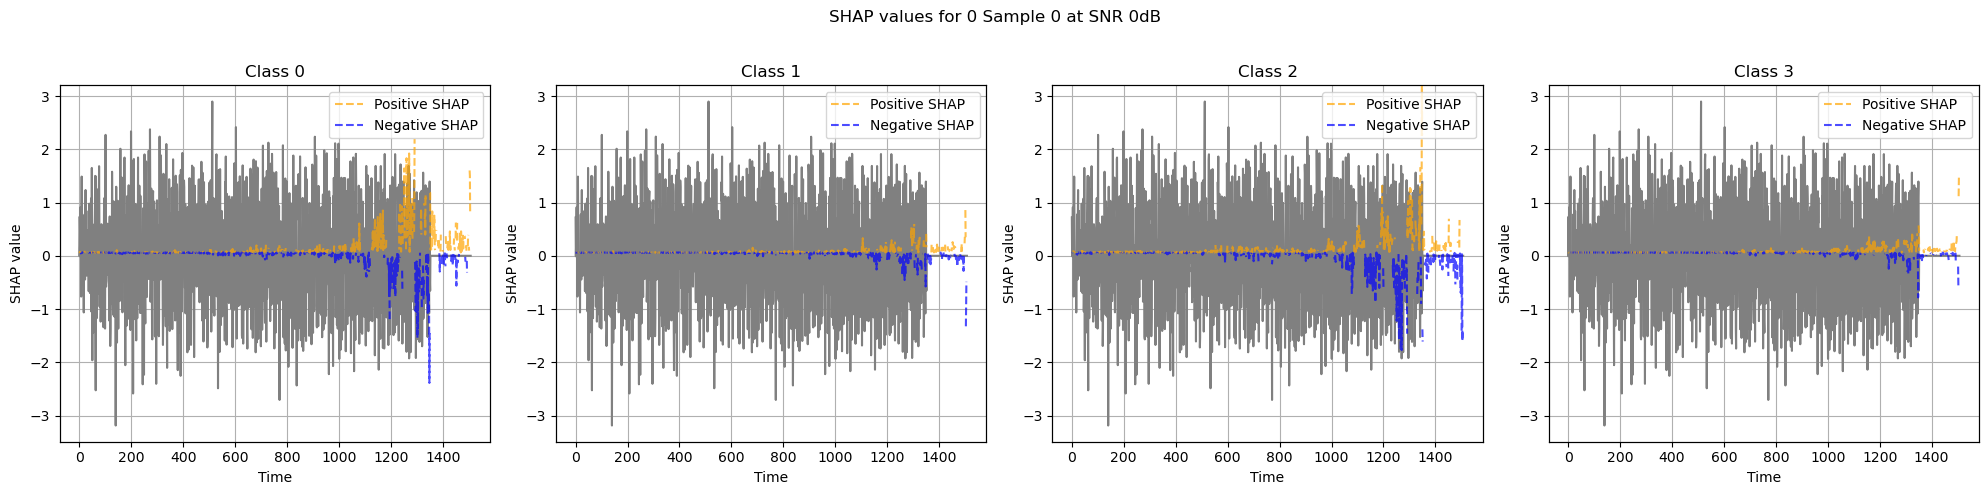

In [5]:
import numpy as np
from explainer import LRPExplainer

def explain_mode(dataset):
    print(f"Size of test dataset: {len(dataset)}")
    for snr in range(params['snr_min'], params['snr_max']+1, 2):
        ckpt = os.path.join("./ckpts/", snr_str:=f"-{snr}dB" if snr != 0 else "0dB")
        ckpts = [f for f in os.listdir(ckpt) if f.endswith(".pt")]

        LSTMmodel = BiLSTM(params['input_size'], params['hidden_size'], 
                    params['num_layers'], params['num_classes']).to(c.device)
        LSTMmodel.load_state_dict(torch.load(f"{ckpt}/{ckpts[0]}"))
        LSTMmodel.train() # train mode for SHAP
        
        explainer = None
        dataset_batch = DataLoader(dataset, batch_size=params['batch_size'], shuffle=False, collate_fn=collate)
        for data, labels, _ in dataset_batch:
            data = data.to(c.device)
            
            if explainer is None:
                explainer = shap.GradientExplainer(LSTMmodel, data)
            
            LSTMmodel.train()
            shap_values = explainer.shap_values(data)  # shap : (64, 1835, 2, 4) / data :torch.Size([64, 1835, 2])     
            
            num_classes = shap_values.shape[3]
            for i, d, l in zip(range(len(data)), data, labels):                
                fig, axs = plt.subplots(1, num_classes, figsize=(20, 5))
                for class_idx in range(num_classes): 
                    shap_class = shap_values[i, :, :, class_idx].sum(axis=1)
                    
                    real_data = data[i, :, 0].cpu().numpy()
                    imag_data = data[i, :, 1].cpu().numpy()
                    
                    axs[class_idx].plot(real_data, color='gray') # plot(x, y)
                    
                    shap_pos = np.where(shap_class >= 0, shap_class, np.nan)
                    shap_neg = np.where(shap_class < 0, shap_class, np.nan)
                    
                    ax2 = axs[class_idx].twinx()
                    ax2.plot(shap_pos, label='Positive SHAP', color='orange', linestyle='--', alpha=0.7)
                    ax2.plot(shap_neg, label='Negative SHAP', color='blue', linestyle='--', alpha=0.7)
 
                    ax2.set_ylim(-0.06, 0.053)
                    ax2.set_yticks([])
                    ax2.legend(loc='upper right')
                    
                    axs[class_idx].set_title(f'Class {class_idx}')
                    axs[class_idx].set_xlabel('Time')
                    axs[class_idx].set_ylabel('SHAP value')
                    
                    axs[class_idx].grid(True)
                    
                plt.suptitle(f'SHAP values for {l} Sample {i} at SNR {snr_str}')
                plt.tight_layout(rect=[0, 0, 1, 0.96])
                plt.show()
                break
            break
        break
        
explain_mode(explain_dataset)

# 데이터셋을 불러오는 과정에서 패딩은 해당 배치에서 가장 길이가 긴 값을 기준으로 이루어지기 때문에 data의 일부가 0으로 되어있을 수 있음
# 
# shap 값은 해당 데이터의 실제 값과 비교하여 어떤 부분이 중요한지를 나타내는 값이기 때문에 0으로 패딩된 부분은 중요하지 않음
# 따라서 shap 값을 보기 위해서는 해당 데이터의 실제 값만을 보는 것이 좋음
# 이를 반영해 코드는 수정

In [1]:
import os
import re
import torch
import glob
import json

import numpy as np
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from TripletConvolution import TCN, trainTCN

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)

signalTypes = ['Barker', 'Costas', 'Frank', 'LFM', 'P1', 'P2', 'P3', 'P4', 'T1', 'T2', 'T3', 'T4']

RawType = "/data/kiwan/dataset-CWD-50/"
TransformedTypes = {'DWT' : "/data/kiwan/Unknown_radar_detection/Adaptive_wavelet_transform/dataset-SPWVD-denoised-Adaptive_DWT",
                    'CWD' : "/data/kiwan/Unknown_radar_detection/Adaptive_wavelet_transform/240523_CWD-v1/",
                    'SAFI' : "/data/kiwan/Unknown_radar_detection/Adaptive_wavelet_transform/240523_SAFI-v1/",}


In [6]:
json_file = 'dataset/CWD_signals.json'

with open(json_file, 'r') as f:
    SignalData = json.load(f)

In [65]:
# [signal_type]>[snr_value]>[step]>[timepoint][real, imag]

import matplotlib.pyplot as plt
from torch.utils.data import Dataset


import torch.nn.utils.rnn as rnn_utils

class RadarSignalDataset(Dataset):
    def __init__(self, signals_data, signal_types, snr_max=17):
        self.data = []
        self.labels = []
        self.label_mapping = {signal: idx for idx, signal in enumerate(signalTypes)}

        for signal_type in signal_types:
            print(f"Data loading for '{signal_type}'", end='')
            for snr_idx, snr in enumerate(range(0, snr_max, 2)): 
                print(".", end='') if snr_idx % 2 == 0 else None
                ssnr = str(snr)
                if ssnr in signals_data[signal_type]: 
                    signal_snr_data = signals_data[signal_type][ssnr]
                    for signal in signal_snr_data:
                        complex_signal = [self.convIQ(x) for x in signal]
                        self.data.append(complex_signal)
                        self.labels.append(signal_type)
            print("Done!")
    
    @staticmethod
    def convIQ(datastring):
        comp = complex(datastring.replace('i', 'j'))
        return comp.real, comp.imag
    
    staticmethod
    def collate(self, batch):
        data, labels = zip(*batch)
        padding = rnn_utils.pad_sequence([torch.tensor(seq, dtype=torch.float32) for seq in data], batch_first=True)
        labels = [self.label_mapping[label] for label in labels]
        labels = torch.tensor(labels, dtype=torch.long)
        return padding, labels
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


In [66]:
typeSize = 4
dataset = RadarSignalDataset(SignalData, signalTypes[0:typeSize], snr_max=17)

Data loading for 'Barker'.....Done!
Data loading for 'Costas'.....Done!
Data loading for 'Frank'.....Done!
Data loading for 'LFM'.....Done!


In [68]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=dataset.collate)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=dataset.collate)

Train batch data size: torch.Size([32, 1856, 2])
Train batch labels: torch.Size([32])
Test batch data size: torch.Size([32, 1920, 2])
Test batch labels: torch.Size([32])


In [72]:
import torch
import torch.nn as nn
import torch.optim as optim

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.5)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Initial hidden state와 cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))     # LSTM 출력: (배치 크기, 시퀀스 길이, hidden state 크기)
        out = self.fc(out[:, -1, :])        # 마지막 타임스텝만 사용하여 출력 계산
        return out

input_size = 2          # (Real, Imag)
hidden_size = 128       # LSTM hidden state size
num_layers = 2          
num_classes = len(signalTypes[:typeSize])  # Expected Output size

model = LSTM(input_size, hidden_size, num_layers, num_classes).to(device)

criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)


In [74]:
num_epochs = 40 
batch_size = 128

for epoch in range(num_epochs):
    model.train()  
    rl = 0.0
    
    for data_batch, labels_batch in train_loader:
        data_batch = data_batch.to(device)
        labels_batch = labels_batch.to(device)

        optimizer.zero_grad()
        outputs = model(data_batch)

        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()

        rl += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {rl/len(train_loader):.4f}')
torch.save(model.state_dict(), f'./lstm_l{rl/len(train_loader):.4f}.pt')

model.eval() 
correct = 0
total = 0

with torch.no_grad():
    for data_batch, labels_batch in test_loader:
        data_batch = data_batch.to(device)
        labels_batch = labels_batch.to(device)
        outputs = model(data_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += labels_batch.size(0)
        correct += (predicted == labels_batch).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')


Epoch [1/40], Loss: 0.4966
Epoch [2/40], Loss: 0.4733
Epoch [3/40], Loss: 0.3970
Epoch [4/40], Loss: 0.5445
Epoch [5/40], Loss: 0.5509
Epoch [6/40], Loss: 0.4634
Epoch [7/40], Loss: 0.3565
Epoch [8/40], Loss: 0.3428
Epoch [9/40], Loss: 0.4956
Epoch [10/40], Loss: 0.5562
Epoch [11/40], Loss: 0.4643
Epoch [12/40], Loss: 0.3316
Epoch [13/40], Loss: 0.2909
Epoch [14/40], Loss: 0.6296
Epoch [15/40], Loss: 0.7437
Epoch [16/40], Loss: 0.5196
Epoch [17/40], Loss: 0.5252


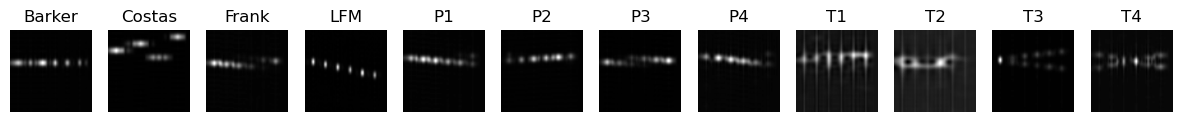

In [5]:
version = 0
targetSNR = 0

vDataset = [(d,l,s) for d, l, s, _ in Dataset if s == targetSNR and signalTypes[l] in signal_groups[f'v{version}']]

plot = {}
for data, label, _ in vDataset:
    signalType = signalTypes[label]
    if signalType not in plot:
        plot[signalType] = data

fig, axs = plt.subplots(1, len(plot))
fig.set_size_inches(15, 5)

for i, (signal_type, image) in enumerate(plot.items()):
    axs[i].imshow(image.squeeze(), cmap='gray')
    axs[i].set_title(signal_type)
    axs[i].axis('off')

plt.show()

In [ ]:
tcn = TCN(input_channel=1).cuda() 
optimizer = optim.Adam(tcn.parameters(), lr=1e-4)


maxSNR = 2
unique_labels = np.unique([l for _, l, _ in vDataset])

for snr in range(0, maxSNR, 2):
    snrDataset = [(d,l,s) for d, l, s in vDataset if s == snr]
    trainTCN(tcn, optim=optimizer, dataset=snrDataset, data_type='DWT', snr=snr, epochs=20)